<a href="https://colab.research.google.com/github/kilonzicharityvivi/Phase_3_Project_2026/blob/main/Predicting_Customer_Churn_for_SyriaTel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Customer Churn for SyriaTel

This notebook builds and evaluates classification models to predict whether a customer will churn (stop doing business) based on historical account and usage features. The goal is to identify *predictable patterns* that SyriaTel can use to prioritize retention outreach and reduce revenue loss.


## 1. Business understanding and success criteria

**Business problem.** Churn is expensive: replacing a lost customer typically costs more than retaining an existing one. SyriaTel wants a model that flags customers at elevated risk of leaving so that retention resources (call campaigns, offers, customer service interventions) can be targeted efficiently.

**Modeling objective.** Predict `churn` (True/False) using tabular customer features.

**Primary metric choice.** In churn prevention, a *false negative* (missed churner) can be more costly than a *false positive* (offering retention treatment to someone who would have stayed). Therefore we prioritize **recall for the churn class** while monitoring **precision** (to avoid wasting offers) and **F1** (balance). We also track **ROC-AUC** as a threshold-independent summary.


In [1]:
# Imports
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 4)
RANDOM_STATE = 42


In [2]:
# Loading the data
# The dataset is stored an uploaded folder named DATA.
# We can also extract from an archive.zip in the working directory.

import zipfile

CANDIDATE_PATHS = [
    Path('DATA/bigml_59c28831336c6604c800002a.csv'),
    Path('data/bigml_59c28831336c6604c800002a.csv'),
    Path('bigml_59c28831336c6604c800002a.csv'),
    Path('extracted/bigml_59c28831336c6604c800002a.csv'),
]

data_path = next((p for p in CANDIDATE_PATHS if p.exists()), None)

# If not found, but archive.zip exists, extract and try again
if data_path is None and Path('archive.zip').exists():
    Path('extracted').mkdir(exist_ok=True)
    with zipfile.ZipFile('archive.zip', 'r') as z:
        z.extractall('extracted')
    data_path = next((p for p in CANDIDATE_PATHS if p.exists()), None)

if data_path is None:
    raise FileNotFoundError(
        "Could not find the dataset file. Expected one of: "
        + ", ".join(str(p) for p in CANDIDATE_PATHS)
        + ". Put the CSV in one of these locations or update CANDIDATE_PATHS."
    )

df = pd.read_csv(data_path)
df.head()


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 2. Data understanding

We check dataset shape, data types, missingness, and class balance. Then we do lightweight EDA to identify obvious issues such as identifier columns, highly collinear features, and simple relationships with churn.


In [3]:
df.shape, df.columns.tolist()


((3333, 21),
 ['state',
  'account length',
  'area code',
  'phone number',
  'international plan',
  'voice mail plan',
  'number vmail messages',
  'total day minutes',
  'total day calls',
  'total day charge',
  'total eve minutes',
  'total eve calls',
  'total eve charge',
  'total night minutes',
  'total night calls',
  'total night charge',
  'total intl minutes',
  'total intl calls',
  'total intl charge',
  'customer service calls',
  'churn'])

In [4]:
# Data types and missing values
summary = pd.DataFrame({
    'dtype': df.dtypes,
    'missing': df.isna().sum(),
    'missing_%': (df.isna().mean()*100).round(2)
})
summary


,dtype,missing,missing_%
state,object,0,0.0
account length,int64,0,0.0
area code,int64,0,0.0
phone number,object,0,0.0
international plan,object,0,0.0
voice mail plan,object,0,0.0
number vmail messages,int64,0,0.0
total day minutes,float64,0,0.0
total day calls,int64,0,0.0
total day charge,float64,0,0.0


In [5]:
# Target distribution (class balance)
churn_counts = df['churn'].value_counts()
churn_props = df['churn'].value_counts(normalize=True).round(4)
churn_counts, churn_props


(churn
 False    2850
 True      483
 Name: count, dtype: int64,
 churn
 False    0.8551
 True     0.1449
 Name: proportion, dtype: float64)

### Quick EDA checks

1) **Identifiers.** `phone number` is an identifier and should be removed.

2) **Collinearity / redundancy.** In this dataset, many `charge` fields are linear transforms of `minutes`. Keeping both usually adds noise and multicollinearity without real predictive value. We'll confirm correlation and keep minutes, dropping charges.

3) **Potential business levers.** Features like `customer service calls` and `international plan` often correlate with dissatisfaction or higher-value plans. We'll inspect simple churn rates by these fields to sanity-check signal.


In [6]:
# 1) Drop obvious identifier
id_cols = ['phone number']

# 2) Check minutes vs charges correlation
minutes_cols = [c for c in df.columns if 'minutes' in c]
charge_cols = [c for c in df.columns if 'charge' in c]

corrs = {}
for m in minutes_cols:
    # Pair each minutes column to its corresponding charge column if it exists
    candidate = m.replace('minutes', 'charge')
    if candidate in df.columns:
        corrs[f"{m} vs {candidate}"] = df[[m, candidate]].corr().iloc[0,1]

pd.Series(corrs).sort_values(ascending=False)


,0
total day minutes vs total day charge,1.000000
total eve minutes vs total eve charge,1.000000
total night minutes vs total night charge,0.999999
total intl minutes vs total intl charge,0.999993


In [7]:
# 3) Simple churn rate checks for a few categorical fields
for col in ['international plan', 'voice mail plan']:
    rate = df.groupby(col)['churn'].mean().sort_values(ascending=False)
    print(f"\nChurn rate by {col}:\n", rate.round(3))

print("\nChurn rate by customer service calls (binned):")
cs_bins = pd.cut(df['customer service calls'], bins=[-1,0,1,2,3,4,10])
print(df.groupby(cs_bins)['churn'].mean().round(3))



Churn rate by international plan:
 international plan
yes    0.424
no     0.115
Name: churn, dtype: float64

Churn rate by voice mail plan:
 voice mail plan
no     0.167
yes    0.087
Name: churn, dtype: float64

Churn rate by customer service calls (binned):
customer service calls
(-1, 0]    0.132
(0, 1]     0.103
(1, 2]     0.115
(2, 3]     0.103
(3, 4]     0.458
(4, 10]    0.614
Name: churn, dtype: float64


/tmp/ipython-input-2625658336.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(cs_bins)['churn'].mean().round(3))


## 3. Data preparation

We split into train/test using a **stratified** split to preserve churn prevalence, then build preprocessing using a `ColumnTransformer`. This avoids leakage by fitting imputers/encoders/scalers on the training data only, then applying the learned transformations to the test data. Pipelines are best practice for this reason.


In [8]:
# Separate target and features
X = df.drop(columns=['churn'] + id_cols)
y = df['churn'].astype(int)  # 1 = churn, 0 = not churn

# Drop charge columns to reduce redundancy
X = X.drop(columns=charge_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# Identify column types
cat_cols = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

cat_cols, num_cols


(['state', 'international plan', 'voice mail plan'],
 ['account length',
  'area code',
  'number vmail messages',
  'total day minutes',
  'total day calls',
  'total eve minutes',
  'total eve calls',
  'total night minutes',
  'total night calls',
  'total intl minutes',
  'total intl calls',
  'customer service calls'])

In [9]:
# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)


## 4. Modeling and evaluation framework

Phase 3 expects an **iterative modeling** workflow: start with a simple baseline model, then tune/improve it, and compare with at least one nonparametric alternative.

We will build:

- Baseline logistic regression (interpretable)
- Tuned logistic regression (hyperparameter search)
- Baseline decision tree (nonparametric)
- Tuned decision tree
- (Optional) Random forest as an ensemble benchmark

We evaluate on both train and test sets and keep focus on churn-class recall, not just a classification report dump.  


In [10]:
def evaluate_classifier(model, X_train, y_train, X_test, y_test, threshold=0.5):
    """Return key metrics for train and test; supports thresholding using predicted probabilities."""
    # Predicted probabilities if available; else fall back to predict
    if hasattr(model, 'predict_proba'):
        train_proba = model.predict_proba(X_train)[:, 1]
        test_proba = model.predict_proba(X_test)[:, 1]
        yhat_train = (train_proba >= threshold).astype(int)
        yhat_test = (test_proba >= threshold).astype(int)
        train_auc = roc_auc_score(y_train, train_proba)
        test_auc = roc_auc_score(y_test, test_proba)
    else:
        yhat_train = model.predict(X_train)
        yhat_test = model.predict(X_test)
        train_auc = np.nan
        test_auc = np.nan

    metrics = {
        'threshold': threshold,
        'train_recall': recall_score(y_train, yhat_train),
        'test_recall': recall_score(y_test, yhat_test),
        'train_precision': precision_score(y_train, yhat_train),
        'test_precision': precision_score(y_test, yhat_test),
        'train_f1': f1_score(y_train, yhat_train),
        'test_f1': f1_score(y_test, yhat_test),
        'train_accuracy': accuracy_score(y_train, yhat_train),
        'test_accuracy': accuracy_score(y_test, yhat_test),
        'train_roc_auc': train_auc,
        'test_roc_auc': test_auc,
    }
    return metrics


def plot_diagnostics(model, X_test, y_test, threshold=0.5, title_prefix=''):
    """Confusion matrix + ROC/PR curves when predict_proba is available."""
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_test)[:, 1]
        preds = (proba >= threshold).astype(int)
    else:
        preds = model.predict(X_test)
        proba = None

    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=['No churn', 'Churn'])
    disp.plot(values_format='d')
    plt.title(f"{title_prefix}Confusion Matrix (threshold={threshold})")
    plt.show()

    if proba is not None:
        RocCurveDisplay.from_predictions(y_test, proba)
        plt.title(f"{title_prefix}ROC curve")
        plt.show()

        PrecisionRecallDisplay.from_predictions(y_test, proba)
        plt.title(f"{title_prefix}Precision-Recall curve")
        plt.show()


## 5. Model 1: Baseline logistic regression

Logistic regression is a common churn baseline: it is fast, reasonably interpretable (coefficients), and works well when relationships are approximately linear after preprocessing.

We include `class_weight='balanced'` to reduce bias toward the majority class and help recall for churners when classes are imbalanced.


In [11]:
logreg_baseline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE))
])

logreg_baseline.fit(X_train, y_train)
metrics_logreg_base = evaluate_classifier(logreg_baseline, X_train, y_train, X_test, y_test)
metrics_logreg_base


{'threshold': 0.5,
 'train_recall': 0.7707182320441989,
 'test_recall': 0.7024793388429752,
 'train_precision': 0.3729946524064171,
 'test_precision': 0.3359683794466403,
 'train_f1': 0.5027027027027027,
 'test_f1': 0.45454545454545453,
 'train_accuracy': 0.7791116446578632,
 'test_accuracy': 0.7553956834532374,
 'train_roc_auc': np.float64(0.8496446456409952),
 'test_roc_auc': np.float64(0.796819398884935)}

In [ ]:
plot_diagnostics(logreg_baseline, X_test, y_test, title_prefix='Baseline Logistic Regression - ')


## 6. Model 2: Tuned logistic regression

We tune regularization strength `C` to manage the bias–variance tradeoff and potentially improve generalization. We use stratified cross-validation and optimize for **recall** (our primary business metric).


In [12]:
logreg_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE))
])

param_grid_logreg = {
    'model__C': [0.01, 0.1, 1.0, 10.0, 100.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_logreg = GridSearchCV(
    logreg_pipe,
    param_grid=param_grid_logreg,
    scoring='recall',
    cv=cv,
    n_jobs=-1
)

grid_logreg.fit(X_train, y_train)

grid_logreg.best_params_, grid_logreg.best_score_


({'model__C': 0.01}, np.float64(0.7405631659056316))

In [13]:
logreg_tuned = grid_logreg.best_estimator_
metrics_logreg_tuned = evaluate_classifier(logreg_tuned, X_train, y_train, X_test, y_test)
metrics_logreg_tuned


{'threshold': 0.5,
 'train_recall': 0.7707182320441989,
 'test_recall': 0.7107438016528925,
 'train_precision': 0.3522727272727273,
 'test_precision': 0.33204633204633205,
 'train_f1': 0.48353552859618715,
 'test_f1': 0.45263157894736844,
 'train_accuracy': 0.7615046018407363,
 'test_accuracy': 0.750599520383693,
 'train_roc_auc': np.float64(0.8252907856058862),
 'test_roc_auc': np.float64(0.8033799682403533)}

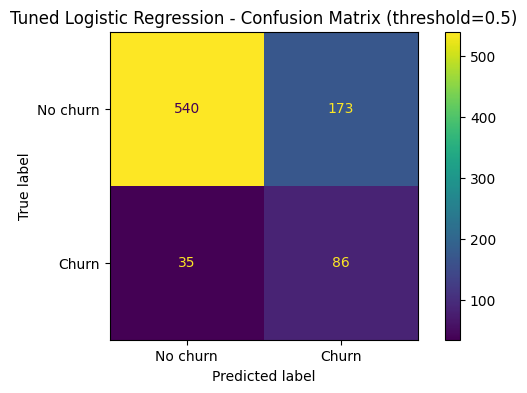

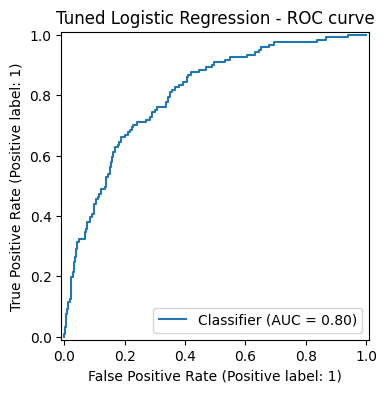

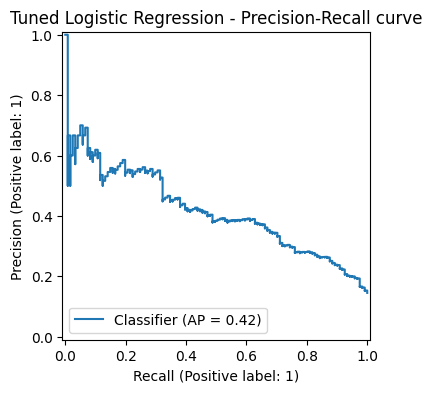

In [14]:
plot_diagnostics(logreg_tuned, X_test, y_test, title_prefix='Tuned Logistic Regression - ')


## 7. Model 3: Baseline decision tree

A decision tree can capture non-linear relationships and interactions without scaling assumptions. The tradeoff is that a single tree can overfit if unconstrained.


In [15]:
tree_baseline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

tree_baseline.fit(X_train, y_train)
metrics_tree_base = evaluate_classifier(tree_baseline, X_train, y_train, X_test, y_test)
metrics_tree_base


{'threshold': 0.5,
 'train_recall': 1.0,
 'test_recall': 0.6446280991735537,
 'train_precision': 1.0,
 'test_precision': 0.6446280991735537,
 'train_f1': 1.0,
 'test_f1': 0.6446280991735537,
 'train_accuracy': 1.0,
 'test_accuracy': 0.8968824940047961,
 'train_roc_auc': np.float64(1.0),
 'test_roc_auc': np.float64(0.7921597718869172)}

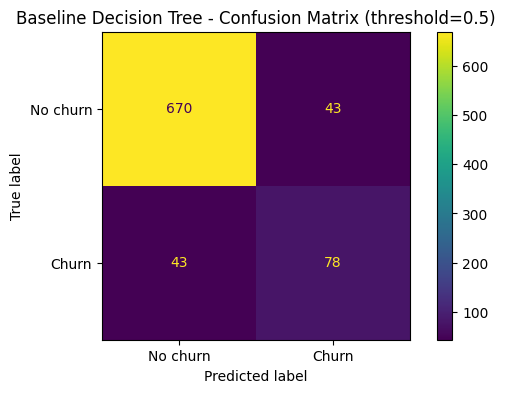

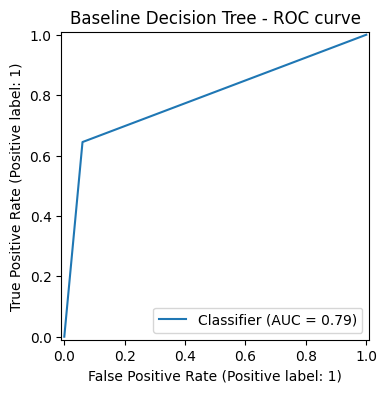

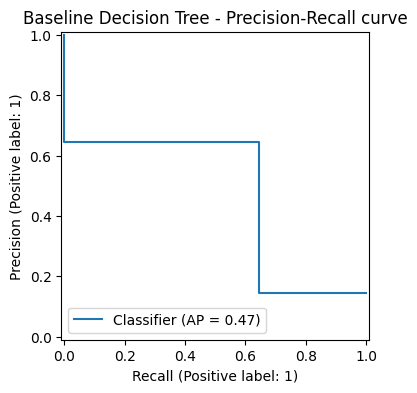

In [16]:
plot_diagnostics(tree_baseline, X_test, y_test, title_prefix='Baseline Decision Tree - ')


## 8. Model 4: Tuned decision tree

We tune tree depth and split criteria to reduce overfitting and improve generalization. We again optimize for churn recall.


In [17]:
tree_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

param_grid_tree = {
    'model__max_depth': [2, 3, 4, 5, 6, None],
    'model__min_samples_split': [2, 10, 25, 50],
    'model__min_samples_leaf': [1, 5, 10, 25],
    'model__criterion': ['gini', 'entropy']
}

grid_tree = GridSearchCV(
    tree_pipe,
    param_grid=param_grid_tree,
    scoring='recall',
    cv=cv,
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

grid_tree.best_params_, grid_tree.best_score_


({'model__criterion': 'entropy',
  'model__max_depth': None,
  'model__min_samples_leaf': 25,
  'model__min_samples_split': 2},
 np.float64(0.8286910197869102))

In [18]:
tree_tuned = grid_tree.best_estimator_
metrics_tree_tuned = evaluate_classifier(tree_tuned, X_train, y_train, X_test, y_test)
metrics_tree_tuned


{'threshold': 0.5,
 'train_recall': 0.9088397790055248,
 'test_recall': 0.7933884297520661,
 'train_precision': 0.591726618705036,
 'test_precision': 0.4824120603015075,
 'train_f1': 0.7167755991285403,
 'test_f1': 0.6,
 'train_accuracy': 0.8959583833533413,
 'test_accuracy': 0.8465227817745803,
 'train_roc_auc': np.float64(0.9738848801826281),
 'test_roc_auc': np.float64(0.8617470123908987)}

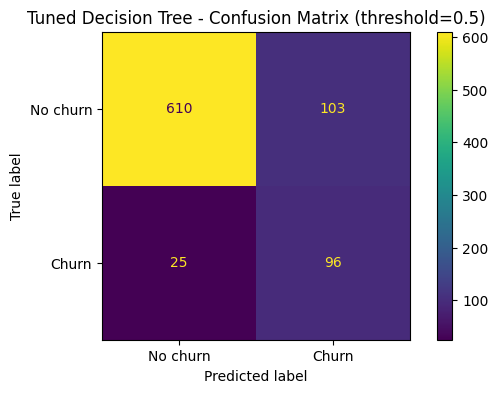

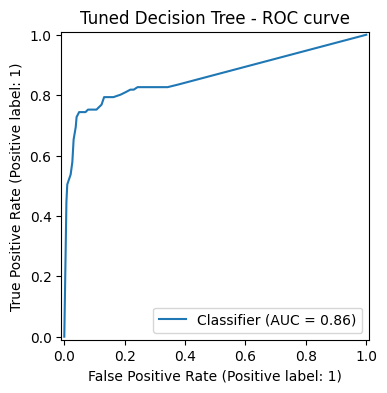

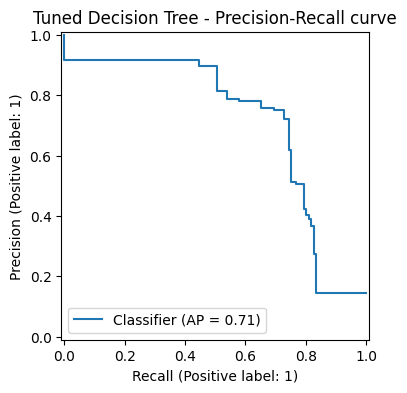

In [19]:
plot_diagnostics(tree_tuned, X_test, y_test, title_prefix='Tuned Decision Tree - ')


## 9. Optional: Random forest benchmark

A random forest averages many decision trees to reduce variance and often improves predictive performance. We include it as a benchmark; it may trade interpretability for accuracy/recall gains.


In [20]:
rf_baseline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    ))
])

rf_baseline.fit(X_train, y_train)
metrics_rf = evaluate_classifier(rf_baseline, X_train, y_train, X_test, y_test)
metrics_rf


{'threshold': 0.5,
 'train_recall': 1.0,
 'test_recall': 0.5041322314049587,
 'train_precision': 1.0,
 'test_precision': 0.8970588235294118,
 'train_f1': 1.0,
 'test_f1': 0.6455026455026455,
 'train_accuracy': 1.0,
 'test_accuracy': 0.919664268585132,
 'train_roc_auc': np.float64(1.0),
 'test_roc_auc': np.float64(0.8833876183742306)}

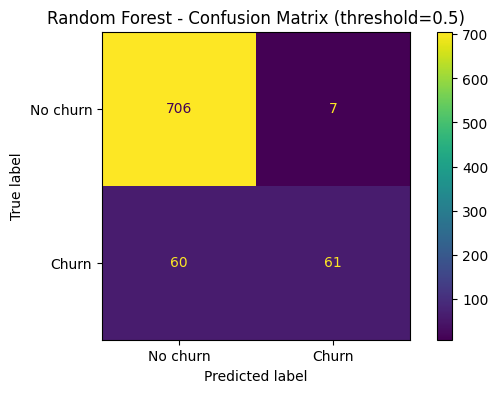

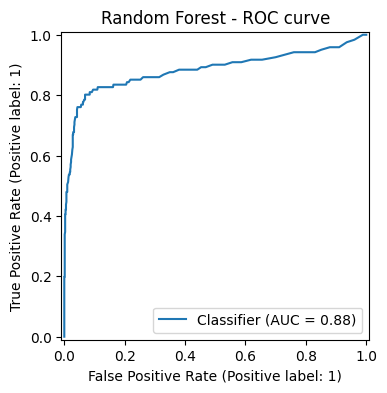

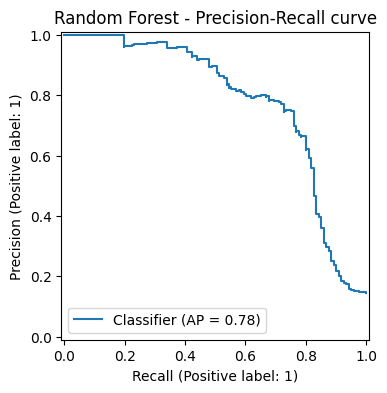

In [21]:
plot_diagnostics(rf_baseline, X_test, y_test, title_prefix='Random Forest - ')


## 10. Model comparison

We compare models side-by-side, focusing on **test recall** for churners as the primary business metric, while checking precision, F1, and AUC.


In [22]:
results = pd.DataFrame([
    {'model': 'logreg_baseline', **metrics_logreg_base},
    {'model': 'logreg_tuned', **metrics_logreg_tuned},
    {'model': 'tree_baseline', **metrics_tree_base},
    {'model': 'tree_tuned', **metrics_tree_tuned},
    {'model': 'rf_baseline', **metrics_rf}
])

cols = ['model','test_recall','test_precision','test_f1','test_roc_auc','test_accuracy',
        'train_recall','train_precision','train_f1','train_roc_auc','train_accuracy']
results[cols].sort_values('test_recall', ascending=False)


,model,test_recall,test_precision,test_f1,test_roc_auc,test_accuracy,train_recall,train_precision,train_f1,train_roc_auc,train_accuracy
3,tree_tuned,0.793388,0.482412,0.600000,0.861747,0.846523,0.908840,0.591727,0.716776,0.973885,0.895958
1,logreg_tuned,0.710744,0.332046,0.452632,0.803380,0.750600,0.770718,0.352273,0.483536,0.825291,0.761505
0,logreg_baseline,0.702479,0.335968,0.454545,0.796819,0.755396,0.770718,0.372995,0.502703,0.849645,0.779112
2,tree_baseline,0.644628,0.644628,0.644628,0.792160,0.896882,1.000000,1.000000,1.000000,1.000000,1.000000
4,rf_baseline,0.504132,0.897059,0.645503,0.883388,0.919664,1.000000,1.000000,1.000000,1.000000,1.000000


## 11. Threshold tuning for business tradeoffs

Most retention programs have capacity constraints: we may only be able to contact the top *N* highest-risk customers each week/month. Instead of treating 0.5 as a fixed decision threshold, we can tune the probability threshold to hit a desired recall or precision level.

Below we demonstrate how recall/precision shift as the threshold changes using the best-performing probability model (logistic regression or random forest).


In [23]:
# Choose a model for threshold analysis
final_proba_model = rf_baseline  # change to logreg_tuned if it performs better for the business goals

thresholds = np.linspace(0.05, 0.95, 19)
rows = []
for t in thresholds:
    rows.append({'threshold': t, **evaluate_classifier(final_proba_model, X_train, y_train, X_test, y_test, threshold=t)})

thresh_df = pd.DataFrame(rows)
thresh_df[['threshold','test_recall','test_precision','test_f1']].sort_values('threshold')


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,threshold,test_recall,test_precision,test_f1
0,0.05,0.900826,0.223361,0.357964
1,0.10,0.851240,0.370504,0.516291
2,0.15,0.834711,0.465438,0.597633
3,0.20,0.826446,0.537634,0.651466
4,0.25,0.809917,0.620253,0.702509
5,0.30,0.768595,0.678832,0.720930
6,0.35,0.735537,0.747899,0.741667
7,0.40,0.677686,0.788462,0.728889
8,0.45,0.595041,0.808989,0.685714
9,0.50,0.504132,0.897059,0.645503


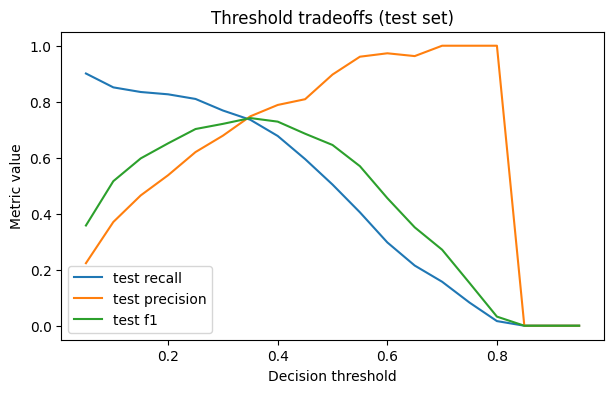

In [24]:
# Plot recall vs precision across thresholds
plt.plot(thresh_df['threshold'], thresh_df['test_recall'], label='test recall')
plt.plot(thresh_df['threshold'], thresh_df['test_precision'], label='test precision')
plt.plot(thresh_df['threshold'], thresh_df['test_f1'], label='test f1')
plt.xlabel('Decision threshold')
plt.ylabel('Metric value')
plt.title('Threshold tradeoffs (test set)')
plt.legend();
plt.show()


## 12. Interpretation: what features matter?

For stakeholders, it is not enough to know “the model works.” We need to interpret plausible drivers.

- For logistic regression, coefficients indicate directionality (after preprocessing).
- For tree/forest models, feature importance can be extracted, but should be interpreted cautiously (importance ≠ causality).

Below is a straightforward feature-importance view using the random forest model.


In [25]:
# Get feature names after preprocessing
# Works for scikit-learn >= 1.0
feature_names = rf_baseline.named_steps['preprocess'].get_feature_names_out()

importances = rf_baseline.named_steps['model'].feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
fi.head(15)


,0
num__total day minutes,0.205697
num__customer service calls,0.135381
num__total eve minutes,0.072353
num__total intl minutes,0.054848
num__total night minutes,0.052621
num__total day calls,0.046411
num__account length,0.045887
cat__international plan_yes,0.043198
num__total eve calls,0.043182
cat__international plan_no,0.042908


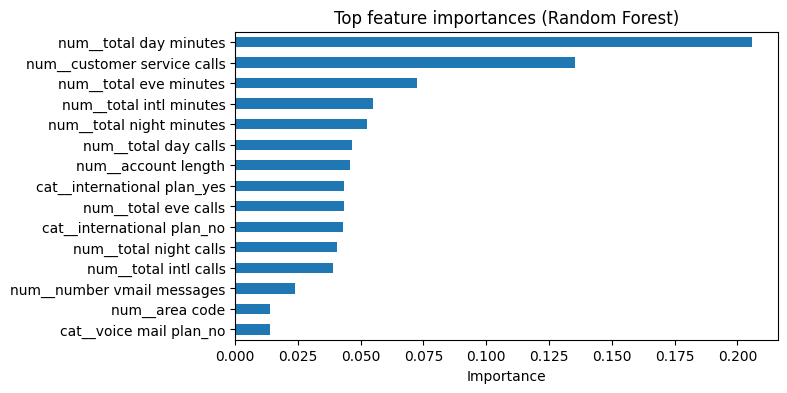

In [26]:
# Plot top 15 feature importances
fi.head(15).sort_values().plot(kind='barh')
plt.title('Top feature importances (Random Forest)')
plt.xlabel('Importance')
plt.show()


## 13. Conclusions, limitations, and recommendations

**Conclusions.** Based on test-set performance, select the model that best balances SyriaTel’s business priorities—typically high churn recall with acceptable precision. Your comparison table above should make this choice explicit, and your threshold analysis should show how to tune outreach volume.

**Limitations.** (1) This dataset is a static snapshot; churn in reality is time-dependent, so performance may shift as customer behavior changes. (2) Features here are limited (no tenure-by-product, complaints text, network quality, pricing history, etc.). (3) Model interpretation indicates association, not causation—changing a high-importance feature may not reduce churn without experimental validation.

**Recommendations.** Use the model to create a ranked “at-risk” list weekly or monthly. Pair it with an intervention strategy (i.e., proactive customer service callbacks for high `customer service calls`, targeted international plan offers, or service-quality investigations). Validate ROI with A/B testing: treat a subset of high-risk customers and measure churn reduction vs control. Monitor model drift and retrain on fresh data periodically.
